In [27]:
import pandas as pd 
import numpy as np 


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

from prophet import Prophet 
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt 
%matplotlib inline

import itertools

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

import holidays

import plotly.graph_objs as go

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot
plt.style.use('fivethirtyeight')

In [28]:
df = pd.read_csv('lrpd-clean.csv')
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'])
df = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df.columns = ['ds', 'y']

# Split the data into train and test sets
df['pre_covid'] = pd.to_datetime(df['ds']) < pd.to_datetime('2020-03-21')
df['post_covid'] = ~df['pre_covid']

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [29]:
finalDf = pd.read_csv('final-lrpd-data.csv')
list2 = ['is_holiday', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'is_weekend', 'is_weekday',
       'season', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
estimator = Ridge()
selector = RFECV(estimator, step=10, cv=10)
selector = selector.fit(finalDf[list2], finalDf['y'])
to_keep = finalDf[list2].columns[selector.support_]


In [30]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06', 'upper_window': 77},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27', 'upper_window': 110},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17', 'upper_window': 4},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10', 'upper_window': 13},
])

m3_changepoints = (
    # 10 potential changepoints in 2.5 years
    pd.date_range('2017-06-02', '2020-01-01', periods=10).date.tolist() +
    # 15 potential changepoints in 1 year 2 months
    pd.date_range('2020-02-01', '2021-04-01', periods=15).date.tolist()
)

In [31]:
np.random.seed(42)
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.5],
    'seasonality_prior_scale': [0.01, 10],
    'holidays_prior_scale': [0.01, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True, False],
    'holidays': [lockdowns],
    'changepoints': [m3_changepoints]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:

    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
    )
    m.add_seasonality(
        name='weekly_post_covid',
        period=7,
        fourier_order=3,
        condition_name='post_covid',
    )
    # Add regressors to the dataframe
    for f in to_keep:
        df[f] = finalDf[f]
        m.add_regressor(f)

    train_size = int(len(df) * 0.8)
    train_df = df[:train_size]
    test_df = df[train_size:]

    m.fit(train_df)

    future_train = train_df.drop(columns=['y']).copy()
    future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
    future_train['post_covid'] = ~future_train['pre_covid']
   
    for f in to_keep:
        future_train[f] = finalDf[f][:train_size]

    forecast_train = m.predict(future_train)

    # Evaluate performance on the train set
    y_true_train = train_df['y'].values
    y_pred_train = forecast_train['yhat'].values[:len(train_df)]
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

    print("Train RMSE:", rmse_train)

    future_test = test_df.drop(columns=['y']).copy()
    future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
    future_test['post_covid'] = ~future_test['pre_covid']
    # Evaluate performance on the test set
    for f in to_keep:
        future_test[f] = finalDf[f][train_size:]

    forecast_test = m.predict(future_test)

    y_true_test = test_df['y'].values
    y_pred_test = forecast_test['yhat'].values[-len(test_df):]
    rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

    rmses.append(rmse_test_weather)


# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:52 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.721414545372114


18:18:53 - cmdstanpy - INFO - Chain [1] start processing
18:18:53 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.831219356122382


18:18:54 - cmdstanpy - INFO - Chain [1] start processing
18:18:54 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.729286738255866


18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.840006138056904


18:18:56 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.880918674981554


18:18:57 - cmdstanpy - INFO - Chain [1] start processing
18:18:57 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.026380273964199


18:18:58 - cmdstanpy - INFO - Chain [1] start processing
18:18:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.927261373763784


18:18:59 - cmdstanpy - INFO - Chain [1] start processing
18:18:59 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.053422545617419


18:19:00 - cmdstanpy - INFO - Chain [1] start processing
18:19:00 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.710283122477661


18:19:01 - cmdstanpy - INFO - Chain [1] start processing
18:19:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.826568542177538


18:19:02 - cmdstanpy - INFO - Chain [1] start processing
18:19:02 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.720909801797481


18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:03 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.816015043745819


18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.918910831033566


18:19:05 - cmdstanpy - INFO - Chain [1] start processing
18:19:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.030447746819522


18:19:06 - cmdstanpy - INFO - Chain [1] start processing
18:19:06 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.937962259902483


18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.076994047194972


18:19:08 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.711288476688243


18:19:09 - cmdstanpy - INFO - Chain [1] start processing
18:19:09 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8154926476953275


18:19:09 - cmdstanpy - INFO - Chain [1] start processing
18:19:10 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.714173624744627


18:19:10 - cmdstanpy - INFO - Chain [1] start processing
18:19:10 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.82525011262562


18:19:11 - cmdstanpy - INFO - Chain [1] start processing
18:19:11 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.760799285013702


18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.889557788289345


18:19:13 - cmdstanpy - INFO - Chain [1] start processing
18:19:13 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.833731983086179


18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8873189195784565


18:19:15 - cmdstanpy - INFO - Chain [1] start processing
18:19:15 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.690873522459348


18:19:16 - cmdstanpy - INFO - Chain [1] start processing
18:19:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.805056550011082


18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.696975164816211


18:19:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:18 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.804046771989323


18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8729800164556485


18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.973873000197149


18:19:21 - cmdstanpy - INFO - Chain [1] start processing
18:19:21 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.882877518430281


18:19:22 - cmdstanpy - INFO - Chain [1] start processing
18:19:22 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.050995890883469


18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:24 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.167196262620689


18:19:25 - cmdstanpy - INFO - Chain [1] start processing
18:19:26 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.271044676039409


18:19:27 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.165287015775838


18:19:29 - cmdstanpy - INFO - Chain [1] start processing
18:19:30 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2726526562235


18:19:31 - cmdstanpy - INFO - Chain [1] start processing
18:19:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2456397243216


18:19:32 - cmdstanpy - INFO - Chain [1] start processing
18:19:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.348491489522036


18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:35 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.252307117448315


18:19:35 - cmdstanpy - INFO - Chain [1] start processing
18:19:36 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.3511608766789385


18:19:37 - cmdstanpy - INFO - Chain [1] start processing
18:19:38 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.5745629538257075


18:19:39 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.694128133397165


18:19:41 - cmdstanpy - INFO - Chain [1] start processing
18:19:42 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.576356265363822


18:19:43 - cmdstanpy - INFO - Chain [1] start processing
18:19:44 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.6941152751419075


18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:47 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.6706090906196405


18:19:48 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.720876428131471


18:19:50 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.667112876752268


18:19:53 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.720974275753401


18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.138736780874536


18:19:58 - cmdstanpy - INFO - Chain [1] start processing
18:19:59 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2592196411824705


18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.13974508814477


18:20:02 - cmdstanpy - INFO - Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.259426551693983


18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.155230788976825


18:20:05 - cmdstanpy - INFO - Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.2760217975644395


18:20:07 - cmdstanpy - INFO - Chain [1] start processing
18:20:08 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.157271921621268


18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.274841381121727


18:20:10 - cmdstanpy - INFO - Chain [1] start processing
18:20:12 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.555401925368804


18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.680598856972859


18:20:15 - cmdstanpy - INFO - Chain [1] start processing
18:20:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.556921166082639


18:20:17 - cmdstanpy - INFO - Chain [1] start processing
18:20:18 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.6812337197314795


18:20:19 - cmdstanpy - INFO - Chain [1] start processing
18:20:22 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.53569538879933


18:20:23 - cmdstanpy - INFO - Chain [1] start processing
18:20:26 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.657630638176819


18:20:27 - cmdstanpy - INFO - Chain [1] start processing
18:20:29 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.53755659810746


18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 6.661894353308856
    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                     0.001                     0.01                  0.01  \
1                     0.001                     0.01                  0.01   
2                     0.001                     0.01                  0.01   
3                     0.001                     0.01                  0.01   
4                     0.001                     0.01                  0.01   
..                      ...                      ...                   ...   
59                    0.500                    10.00                 10.00   
60                    0.500                    10.00                 10.00   
61                    0.500                    10.00                 10.00   
62                    0.500                    10.00                 10.00   
63                    0.500                    10.00                 10.00   

   seasonality_mode  daily_season

In [32]:
np.random.seed(42)
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)
# Add regressors to the dataframe
for f in to_keep:
    df[f] = finalDf[f]
    m.add_regressor(f)

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

m.fit(train_df)

future_train = train_df.drop(columns=['y']).copy()
future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
future_train['post_covid'] = ~future_train['pre_covid']

for f in to_keep:
    future_train[f] = finalDf[f][:train_size]

forecast_train = m.predict(future_train)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

future_test = test_df.drop(columns=['y']).copy()
future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
future_test['post_covid'] = ~future_test['pre_covid']
# Evaluate performance on the test set
for f in to_keep:
    future_test[f] = finalDf[f][train_size:]

forecast_test = m.predict(future_test)

y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2_test = r2_score(y_true_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test)
mse_test = mean_squared_error(y_true_test, y_pred_test)
print("Test RMSE:", rmse_test_weather)
print('Test R2', r2_test)
print('MAPE', mape_test)
print("MSE:", mean_squared_error(y_true_test, y_pred_test))

18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.157271921621268
Test RMSE: 7.5646519063390265
Test R2 0.30631117590195156
MAPE 0.17422262786584322
MSE: 57.22395846407867


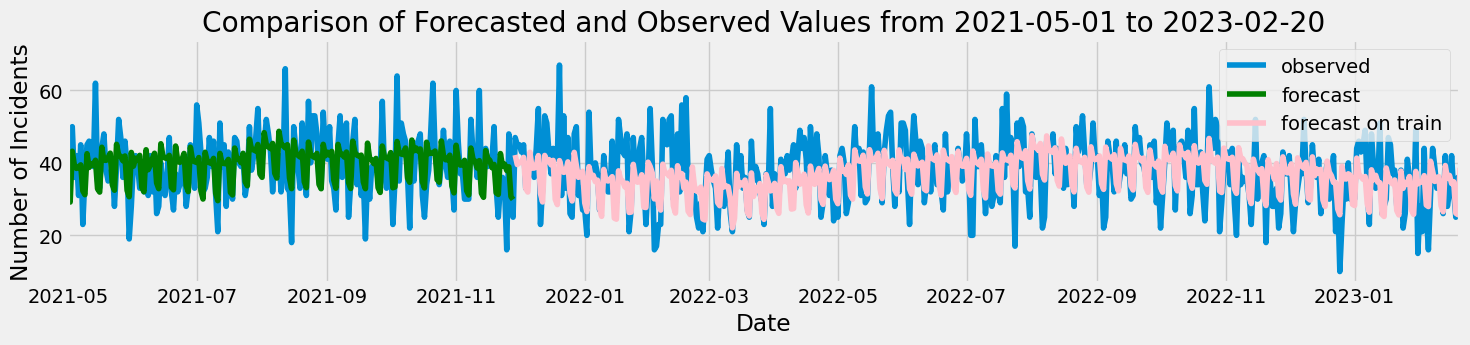

In [33]:
plt.figure(figsize=(13, 5))
plt.plot(df.ds, df.y, label='observed')


plt.plot(forecast_train['ds'], forecast_train['yhat'],
         label='forecast', color='green')
plt.plot(forecast_test['ds'], forecast_test['yhat'],
         label='forecast on train', color='pink')
plt.title('Comparison of Forecasted and Observed Values from 2021-05-01 to ' + str(forecast_test.ds.iloc[-1])[:10])
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()


plt.xlim(pd.Timestamp('2021-05-01'), pd.Timestamp(forecast_test.ds.iloc[-1]))
plt.gcf().set_size_inches(16, 3)
plt.savefig('../neural-prophet-forecast.png')
plt.show() 